# Comparison of LSTM vs. DWT and TDDR on Synthetic Data

This notebook benchmarks the LSTM model against two baselines—Discrete Wavelet Transform (DWT) and Temporal Derivative Distribution Repair (TDDR)—using a 60-second synthetic signal with known ground truth. The workflow generally follows our experimental evaluations with additional quantitative analyses. For questions, please contact Jingyi Wu (jingyiwu@andrew.cmu.edu).

## General Pipeline
1. **Process the same input** with LSTM, DWT, and TDDR.  
2. **Detect systolic peaks** → compute IBI → derive HR.  
3. **Detect valleys** → segment pulses → compute averaged waveforms.  

## Metrics
- **HR accuracy:** Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).  
- **Waveform similarity:** Pearson correlation (r) and absolute time-to-peak difference (Δ|TPP|).  
- **Event detection precision:** Precision = TP + (TP + FP), with a tolerance of **±60 ms** (≈ 3 samples at 50 Hz) for matching detected peaks/valleys to ground truth.


## Import packages

In [1]:
# Uncomment the next line to install your repo dependencies.
# !pip install -r requirements_test.txt

In [2]:
import os
import math
import random

import numpy as np
import h5py
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import plotly.io as pio
pio.renderers.default = 'iframe' # this might create a folder named "iframe_figures" and save the interactive plots generated by this script

from utils import * # custom helper functions
color5 = ['#eb5055', '#405FC1', '#ffaa1c', '#62a140', '#9E3AB7'] # Color for plots

## 1. Load pre-trained LSTM model

In [3]:
# Select device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Candidate model files
model_names = [
    'lstm_full_dataset.pt'
]

model_folder = "models/"

# Pick model by index
idx_model = 0
model_name = model_names[idx_model]
print(f"Model selected: {model_name}")

# Initialize model architecture
model = LSTMDetectionModel(n_hid=256, n_layers=1).to(device)

# Load saved weights
state_dict = torch.load(os.path.join(model_folder, model_name), map_location=device)
model.load_state_dict(state_dict)

# Move model to device (redundant but explicit)
model = model.to(device)

print("Model loaded successfully!")

Device: cpu
Model selected: lstm_full_dataset.pt
Model loaded successfully!


/var/folders/x8/2tyh0lwd3v73c3yx2py26lwm0000gn/T/ipykernel_99798/1008716198.py:21: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



## 2. Load test data and preprocessing

In this section, we load example synthetic noisy signals with ground truth. Users can toggle between them by adjusting the index below.


In [4]:
# Pick dataset
test_file = 'synthetic_dataset1.mat' # (1/f)^1 noise with amplitude 0.2
print("Test file: " + test_file + " is picked!")

# Build full path and load dataset
test_folder = 'synthetic_data/'
test_path = test_folder + test_file
dataset = loadmat(test_path)
print(dataset.keys())

Test file: synthetic_dataset1.mat is picked!
dict_keys(['__header__', '__version__', '__globals__', 'alpha', 'amplitude', 'note', 'signal_test', 'time'])


In [5]:
# For paper analyses and figures, we used idx_signal = 0, for other signals, user might need to manually tune some parameters
idx_signal = 0 # 0-7

# Preproceesed noisy signal
data_pick = dataset['signal_test'][idx_signal,:,0].reshape(-1, 1).T
print(data_pick.shape)  # should be 1 × time

# Ground truth signal
data_clean = dataset['signal_test'][idx_signal,:,1].reshape(-1, 1).T
print(data_clean.shape)  # should be 1 × time

# sampling frequency
# Note: if it differs from 50 Hz (training data fs), it will be resampled later
fs_data = 50.0
print(fs_data)

# Figure title based on filename for plotting
figure_title = f"{test_file.removesuffix('.mat')}"
print(figure_title)


(1, 3000)
(1, 3000)
50.0
synthetic_dataset1


### Preprocessing

Preprocessing steps:

1. Resample to 50 Hz (to match training data).
2. Center signal around zero.
3. Normalize so that pulsations roughly lie in [-1, 1].

Current implementation uses Hilbert transform and envelope detection to auto-scale the pulse amplitude, 
but it is not always perfect. Users may need to manually tune:

  `amplitude_scale` : controls vertical scaling
  
  `offset`          : shifts the center up or down

Practical tips:
   - After normalization, visually check the time trace for appropriate scaling.
   - An additional check is to look at segmented and averaged pulse waveforms 
     (plotted at the end of the script). If normalization is done correctly, both 
     raw and LSTM-processed averaged waveforms should have very similar amplitude and fall roughly within [-1, 1].
   - This step is critical: carefully adjusting scaling leads to much better results.

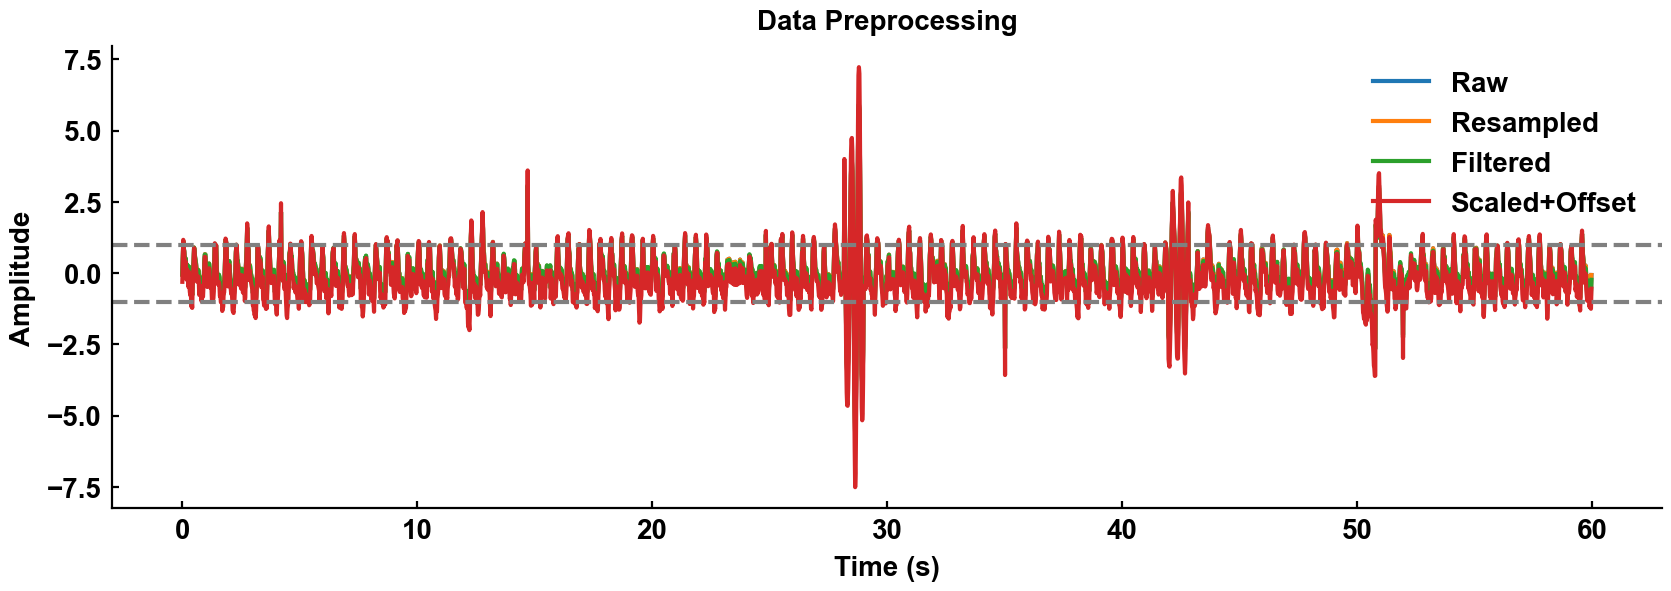

In [6]:
# Still need some preprocessing to center and normalize them
fs_origin = fs_data
fs_target = 50.0 # Training data were sampled at 50 Hz
time_trace_raw = data_pick

amplitude_scale = 1.2
offset = -0.25
t_nirs, time_trace, signal_scale = preprocess_signal(time_trace_raw, fs_origin, fs_target, amplitude_scale=amplitude_scale, offset=offset)

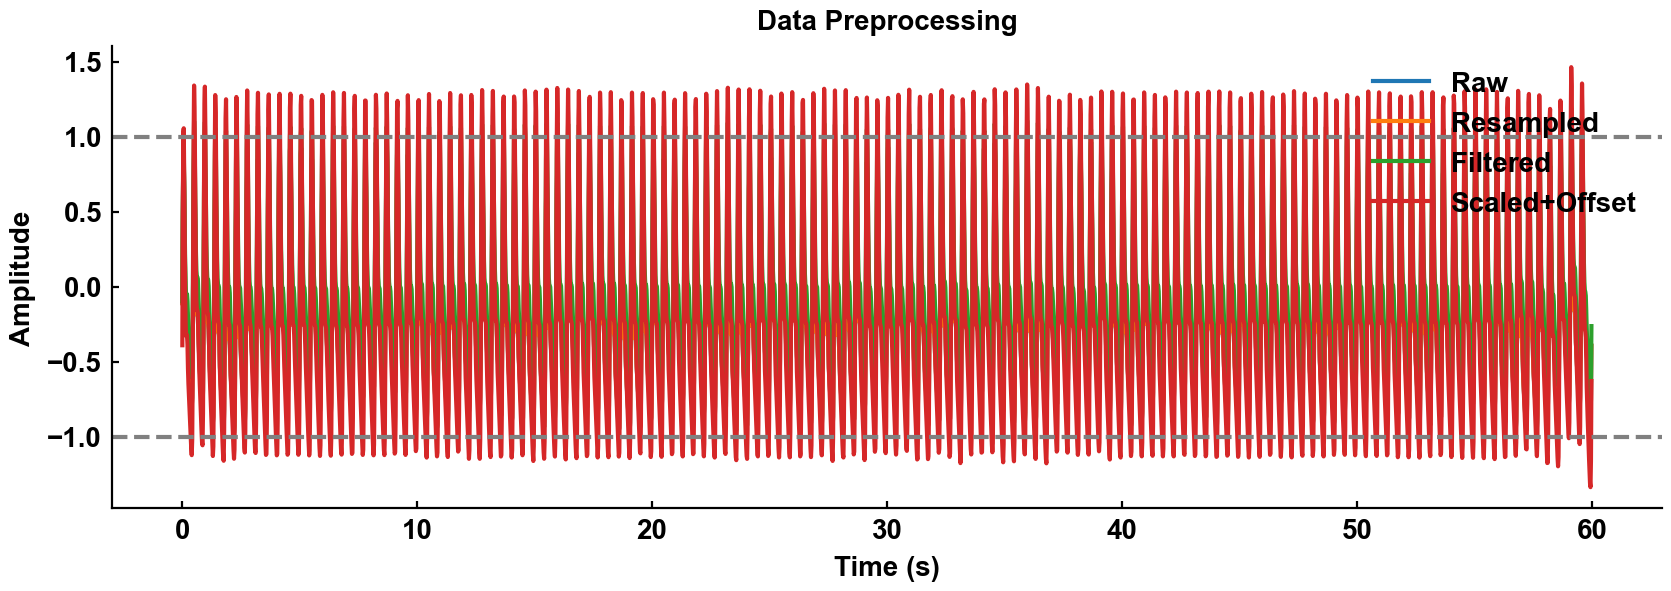

In [7]:
# Same for the ground truth pulsatile signal, for plotting purpose
_, data_clean_filt, _ = preprocess_signal(data_clean, fs_origin, fs_target, amplitude_scale=amplitude_scale, offset=offset)

## 3. Process signal with LSTM

For input signals of arbitrary length, we first segment them into fixed-length windows (the same size used during training).  
Each segment is processed independently by the trained LSTM model, and then recombined into a full-length time trace.  
Overlapping regions between segments are averaged for smooth reconstruction.

We also compare the raw vs. processed signals, estimate the signal quality index (SNR), and visualize spectrograms before and after processing.


In [8]:
# Segmentation parameters
# Window size must match training data length (1 min at 50 Hz → 3000 samples).
# Overlap size can be adjusted: larger overlap = smoother stitching, more compute.
window_size = 3000
overlap_size = 2000

# Segment the full trace into overlapping windows
segments = segment_time_trace(time_trace, window_size, overlap_size)

# Optional: visualize segmentation
# plot_segments(time_trace, segments, window_size, overlap_size, 
#               "Segmented Time Traces")

# Run the trained LSTM model on each segment
processed_segments = process_segments_with_lstm(model, segments, device)

# Recombine processed segments into a single continuous trace
processed_time_trace = combine_processed_segments(processed_segments, window_size, overlap_size, time_trace.shape[1])


**Compare original vs. processed signals**

**Note:**
- Interactive Plotly figure, it might take a long time to run, consider changing the plot setting/renderer or proceeding to later sections.
- Setting plot_segments=True will also show each individual segment.

In [9]:
plot_segments_comparison(time_trace, processed_time_trace, segments, processed_segments, window_size, overlap_size,
    title="Comparison of Original and Processed Segments",
    plot_segments=False)

# Here SNR is defined relative to the difference between clean and noisy signals:
#   signal_power = mean(clean^2)
#   noise_power  = mean((noisy - clean)^2)
#   snr_db       = 10 * log10(signal_power / noise_power)
#
# The plot shows:
#   - Original vs. processed time trace, with low-SNR regions shaded
#   - SNR vs. time curve (based on moving windows)

snr_window_size, snr_step_size, snr_threshold = 50, 25, None
plot_sqi_results_snr(time_trace.squeeze(), processed_time_trace.squeeze(), snr_window_size, snr_step_size, snr_threshold)


In [10]:
# Spectrograms of the signals, this might take a long time
# plot_spectrogram(time_trace, fs_data, title_text="Spectrogram of Original Time Trace")
# plot_spectrogram(processed_time_trace, fs_target, title_text="Spectrogram of Processed Time Trace")


## 4. Process signal with other methods

In addition to the LSTM model, we compare against several conventional signal processing approaches:  

- **Temporal Derivative Distribution Repair (TDDR):** A robust fNIRS motion artifact correction algorithm (used in the paper).  
- **Wavelet filtering:** Removes high- and/or low-frequency coefficients from the wavelet decomposition (used in the paper).
- **Savitzky–Golay filter:** A smoothing filter that can be tried (commented out here).  
- **NeuroKit2’s `ppg_clean`:** A library-based PPG cleaning method (commented out here).  

These methods provide baselines for comparison, helping assess how well the deep learning approach performs relative to classical signal processing techniques.


In [11]:
# TDDR (DOI: 10.1016/j.neuroimage.2018.09.025).
_, tddr_corrected, _, _ = TDDR(time_trace.squeeze(), fs_target, 3)

# Savitzky-Golay filter (optional)
# from scipy.signal import savgol_filter
# sg_corrected = savgol_filter(time_trace.squeeze(), window_length=51, polyorder=5)

# NeuroKit2 PPG cleaning (optional)
# Requires the neurokit2 package.
# import neurokit2 as nk
# nk_corrected = nk.ppg_clean(time_trace.squeeze(), sampling_rate=fs_target, method='elgendi')


In [12]:
# Wavelet filtering
# Step 1: Display frequency bands and maximum decomposition level
wavelet_name='db6'
display_frequency_bands(time_trace.squeeze(), sampling_frequency=fs_target, wavelet_name=wavelet_name)

Wavelet 'db6', fs=50.0 Hz; max level=8
Level 1: 12.50–25.00 Hz
Level 2: 6.25–12.50 Hz
Level 3: 3.12–6.25 Hz
Level 4: 1.56–3.12 Hz
Level 5: 0.78–1.56 Hz
Level 6: 0.39–0.78 Hz
Level 7: 0.20–0.39 Hz
Level 8: 0.10–0.20 Hz


In [13]:
# Step 2: Denoise by zeroing out a fraction of wavelet coefficients
# - selected_levels: which decomposition levels to process
# - percentages: % of coefficients removed
# - remove_both_sides=True: removes both high and low extremes
wt_corrected = wavelet_denoise(time_trace.squeeze(), sampling_frequency=fs_target, selected_levels=[4,5],
                               wavelet_name=wavelet_name, percentages=1, reconstruct_all_bands=False, remove_both_sides=True)

Wavelet='db6', fs=50.0 Hz
  Level 4: 1.56–3.12 Hz
  Level 5: 0.78–1.56 Hz


In [14]:
# Overlay raw, TDDR-corrected, Wavelet-corrected, and LSTM-processed signals.
t = np.arange(0, processed_time_trace.shape[1]) / fs_target
fig = go.Figure()

# Add the traces for each signal
fig.add_trace(go.Scatter(x=t, y=time_trace.squeeze(), mode='lines', name='Raw', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=t, y=tddr_corrected, mode='lines', name='TDDR', line=dict(color='red')))
fig.add_trace(go.Scatter(x=t, y=wt_corrected, mode='lines', name='Wavelet', line=dict(color='green')))
fig.add_trace(go.Scatter(x=t, y=processed_time_trace.squeeze(), mode='lines', name='LSTM', line=dict(color='blue')))
# fig.add_trace(go.Scatter(x=t, y=sg_corrected, mode='lines', name='Savitzky-Golay', line=dict(color='grey')))
# fig.add_trace(go.Scatter(x=t, y=nk_corrected, mode='lines', name='Neurokit', line=dict(color='purple')))

fig.update_layout(
    title="Signal Comparison: Conventional Methods vs LSTM",
    xaxis_title="Time (s)",
    yaxis_title="Amplitude",
    legend=dict(x=0.01, y=0.99),  # Position legend at the top left
    width=1200,
    height=600,
)
fig.show()


### Identify and visualize low-SNR regions

In this subsection, we automatically detect low SNR regions (also see section 3) in the time trace and highlight them in the figure.  
This corresponds to the results figure in the paper, which provides both a global overview and detailed examples of artifact-induced distortions.

**Workflow:**
1. Use `extract_low_snr_regions()` to find regions where the SNR drops below a chosen threshold.  
2. Select the worst `n_regions` (based on minimum SNR), expand their time bounds slightly, and sort them chronologically.  
3. Plot the full time trace with shaded artifact regions (top panel), and zoom into selected regions (bottom row).  


In [15]:
# Step 1: automatically extract candidate low-SNR regions
# Returns start/end times for regions where SNR < threshold,
# sorted from worst (lowest SNR) to best.
low_snr_regions = extract_low_snr_regions(time_trace.squeeze(), processed_time_trace.squeeze(), window_size=50, step_size=25, fs=50, threshold=None)
print("Low SNR Regions (start time, end time):", low_snr_regions,'\n')

# Step 2: expand each region by a small buffer (in seconds) for better visualization
buffer_time = 1 # seconds
regions_to_shade = []
for start_time, end_time in low_snr_regions:
    # Decrease the start time and increase the end time
    new_start_time = max(0, start_time - buffer_time)  # Ensure start time does not go below 0
    new_end_time = end_time + buffer_time
    regions_to_shade.append((new_start_time, new_end_time))

# Step 3: pick the worst few regions to plot (e.g., top 4)
n_regions = 4
if len(regions_to_shade) >= n_regions:
    regions_to_shade = regions_to_shade[0:n_regions]

# Sort the regions chronologically
regions_to_shade = sorted(regions_to_shade, key=lambda x: x[0])
print("Regions to shade (start time, end time):", regions_to_shade)

# For paper figures, we specified the regions manually:
# regions_to_shade = [(12.0, 18.0), (26.0, 32.0), (40.0, 46.0), (49.0, 53.0)]

# But for demonstration purpose, we will just use worst four regions indentified automatically.


Low SNR Regions (start time, end time): [(27.5, 29.5), (41.0, 44.5), (49.5, 53.0), (14.0, 15.5), (34.5, 36.0), (11.5, 13.0), (23.0, 25.5)] 

Regions to shade (start time, end time): [(13.0, 16.5), (26.5, 30.5), (40.0, 45.5), (48.5, 54.0)]


**Paper figure: Comparison of LSTM, DWT, and TDDR**

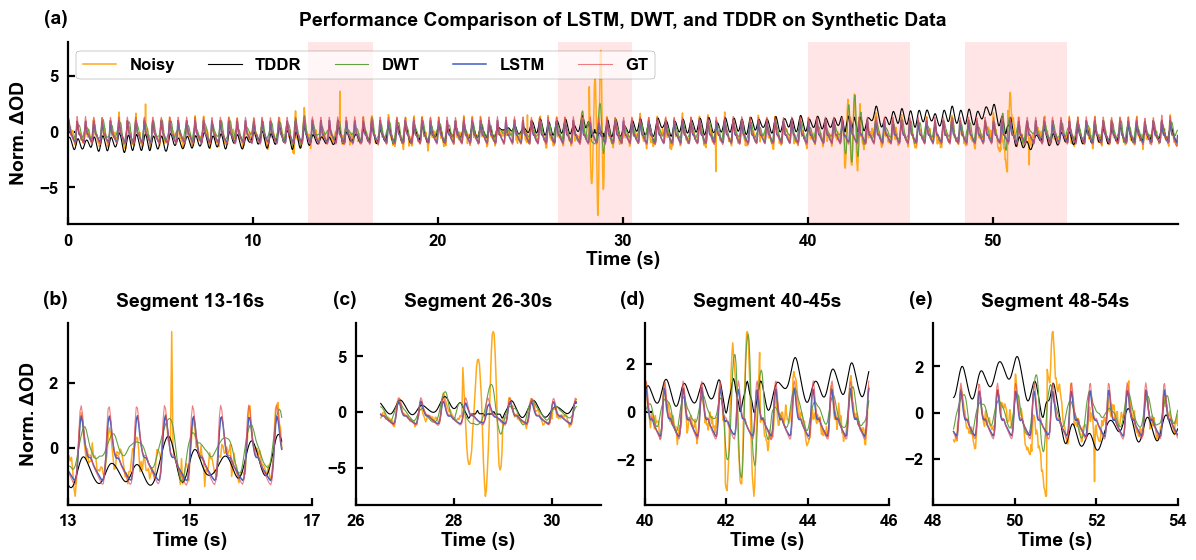

In [16]:
# Non-interactive version as shown in the paper
t = np.arange(0, processed_time_trace.shape[1]) / fs_target

# Create a GridSpec with 2 rows and n columns:
#   Top row: full time trace
#   Bottom row: zoomed-in regions of low SNR
fig = plt.figure(figsize=(7.16, 3))
gs = gridspec.GridSpec(2, len(regions_to_shade), height_ratios=[1, 1])

# Full time trace on the entire top row (spanning all columns)
ax_full_trace = fig.add_subplot(gs[0, :])
ax_full_trace.plot(t, time_trace.squeeze(), label='Noisy', color=color5[2], linewidth=0.55)
ax_full_trace.plot(t, tddr_corrected.squeeze(), label='TDDR', color='k', linewidth=0.4)
ax_full_trace.plot(t, wt_corrected.squeeze(), label='DWT', color=color5[3], linewidth=0.4)
ax_full_trace.plot(t, processed_time_trace.squeeze(), label='LSTM', color=color5[1], linewidth=0.55)
ax_full_trace.plot(t, data_clean_filt.squeeze(), label='GT', color=color5[0], linewidth=0.4, alpha=0.75)

# Shade artifact regions
for start, end in regions_to_shade:
    ax_full_trace.axvspan(start, end, facecolor='red', edgecolor='none', alpha=0.1, label="")

ax_full_trace.set_title('Performance Comparison of LSTM, DWT, and TDDR on Synthetic Data', fontsize=7)
ax_full_trace.set_xlabel('Time (s)', fontsize=7, labelpad=1)
ax_full_trace.set_ylabel('Norm. ΔOD', fontsize=7)
ax_full_trace.spines['top'].set_visible(False)
ax_full_trace.spines['right'].set_visible(False)
ax_full_trace.tick_params(axis='both', which='major', labelsize=6)
ax_full_trace.set_xlim([t[0],t[-1]])

lgd = ax_full_trace.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=5, loc='upper left')
lgd.get_frame().set_linewidth(0.1)

# Add label (a) to the full time trace subplot
ax_full_trace.text(0, 1.18, '(a)', transform=ax_full_trace.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Zoomed-in views in the bottom row
for i, (start, end) in enumerate(regions_to_shade):
    ax = fig.add_subplot(gs[1, i])
    mask = (t >= start) & (t <= end)
    ax.plot(t[mask], time_trace.squeeze()[mask], label='Noisy', color=color5[2], linewidth=0.55)
    ax.plot(t[mask], tddr_corrected.squeeze()[mask], label='TDDR', linestyle='-', color='k', linewidth=0.4)
    ax.plot(t[mask], wt_corrected.squeeze()[mask], label='DWT', linestyle='-', color=color5[3], linewidth=0.4)
    ax.plot(t[mask], processed_time_trace.squeeze()[mask], label='LSTM', color=color5[1], linewidth=0.55)
    ax.plot(t[mask], data_clean_filt.squeeze()[mask], label='GT', color=color5[0], linewidth=0.4, alpha=0.75)
    ax.set_title(f'Segment {int(start)}-{int(end)}s', fontsize=7)
    ax.set_xlabel('Time (s)', fontsize=7, labelpad=1)
    ax.set_ylabel('Norm. ΔOD', fontsize=7) if i == 0 else ax.set_ylabel('')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_xticks(np.arange(np.floor(t[mask][0]), np.ceil(t[mask][-1])+1, 2))
    ax.set_xlim([np.floor(t[mask][0]), np.ceil(t[mask][-1])])
    # Add subplot labels (b), (c), ...
    ax.text(0, 1.18, f'({chr(98 + i)})', transform=ax.transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.subplots_adjust(wspace=0.18, hspace=0.55)  # wspace and hspace control the spacing

# Save figure if needed
# plt.savefig('LSTM_DWT_TDDR_synthetic_data.png', dpi=600, bbox_inches='tight')

plt.show()


## 5. Pulse segmentation and waveform averaging

We use the cleaned LSTM output to detect pulse boundaries (valleys), which are then used to segment both the raw and processed signals into individual beats. From these segments, we compute mean ± STD waveforms. This provides a summary of the pulse morphology and an quality check on preprocessing and normalization.

**Workflow:**
1. Detect valleys on the processed trace (more stable than on raw data).  
2. Use valley indices to segment both raw and processed signals into pulses.  
3. Optionally apply z-score filtering to remove outlier beats.  
4. Compute average and standard deviation waveforms; visualize with shaded error bands.

**Note:** If preprocessing/normalization is appropriate, the averaged raw and LSTM-processed pulses should have similar amplitudes and lie roughly in [−1, 1].


In [17]:
# Find Valleys
# - 'prominence' affects sensitivity; 'distance' ~ half (or less) a cardiac cycle at fs_target.
_, valleys = find_peaks_and_valleys(processed_time_trace.squeeze(), prominence=0.1, distance=0.25*fs_target)

# Plot Noisy and Clean Signal with Pulse Boundaries
# Note: For the interactive plots, plotting many vertical lines can be slow for long signals.
plot_signals_with_boundaries(time_trace.squeeze(), processed_time_trace.squeeze(), fs_target, valleys, title="Noisy and Clean Signal with Pulse Boundaries")


**Compute similarity metrics:**
- **Pearson correlation (r):** quantifies overall similarity in waveform shape.
- **Absolute difference between time-to-peak (Δ|TTP|):** captures temporal alignment of the main peak.

**Note:**
- The current implementation determines TTP by simply locating the maximum value of each pulse. For noisy signals, this can be unstable. A more robust approach would smooth the waveform before peak detection, or define TTP based on an average across several neighboring values.
- During final code cleanup and dataset preparation, the calculated values of r and Δ|TTP| may differ slightly from those reported in the paper due to minor implementation changes.


In [18]:
# Pulse segmentation and averaging for LSTM-processed signal:
results_lstm = segmentation_and_processing(processed_time_trace.squeeze(), valleys, fs_target)

# Pulse segmentation and averaging for raw signal, using LSTM-identified valleys:
results_noisy = segmentation_and_processing(time_trace.squeeze(), valleys, fs_target)

# Pulse segmentation and averaging for ground truth signal, using ground truth valleys:
_, valleys_gt = find_peaks_and_valleys(data_clean.squeeze(), prominence=0.1, distance=0.25*fs_target)
results_gt = segmentation_and_processing(amplitude_scale*data_clean.squeeze(), valleys_gt, fs_target) # amplitude_scale = 1.2 is only for plotting purpose

In [19]:
# Extract variables and calculate similarity metrics:
x_gt = results_gt["x_pulse"]
mean_gt = results_gt["filtered_mean_pulse"]
std_gt = results_gt["filtered_std_pulse"]

x_noisy = results_noisy["x_pulse"]
mean_noisy = results_noisy["filtered_mean_pulse"]
std_noisy = results_noisy["filtered_std_pulse"]

x_lstm = results_lstm["x_pulse"]
mean_lstm = results_lstm["filtered_mean_pulse"]
std_lstm = results_lstm["filtered_std_pulse"]

print('Length of averaged ground truth pulse:', len(x_gt))
print('Length of averaged noisy pulse:', len(x_noisy))
print('Length of averaged LSTM pulse:', len(x_lstm))

Length of averaged ground truth pulse: 23
Length of averaged noisy pulse: 24
Length of averaged LSTM pulse: 24


**Time-to-peak, LSTM vs GT:**

In [20]:
ttp_gt = x_gt[np.argmax(mean_gt)]
ttp_lstm = x_lstm[np.argmax(mean_lstm)]
ttp_noisy = x_noisy[np.argmax(mean_gt)]

delta_ttp = abs(ttp_lstm - ttp_gt)

print(f"ΔTTP = {delta_ttp:.4f} s")

ΔTTP = 0.0000 s


**Pearson R, LSTM vs GT:**

**Note:**

Pulses might have different length, manually adjust them, or interpolate them on a common time axis, so we can calculate Pearson correlation coef.

In [21]:
time_range = (0.0, min(x_gt[-1], x_lstm[-1]))
t_common, pulse_gt_common, pulse_lstm_common = interp_to_common_axis(x_gt, mean_gt, x_lstm, mean_lstm, time_range, fs_target)

r_pearson = pearson_r(pulse_gt_common, pulse_lstm_common)
print(f"\nPearson r = {r_pearson:.3f}")

# Quick demonstration of this interpolation:
# fig, ax = plt.subplots(figsize=(3.0, 2.0))
# ax.plot(t_common,pulse_gt_common,'ro',label='GT')
# ax.plot(t_common,pulse_lstm_common,'bv',label='LSTM')
# ax.legend()
# ax.set_title('Interpolated Pulses on A Common Axis')
# ax.set_ylabel('Amplitude (a.u.)')
# ax.set_xlabel('Time (s)')
# plt.show()



Pearson r = 0.999


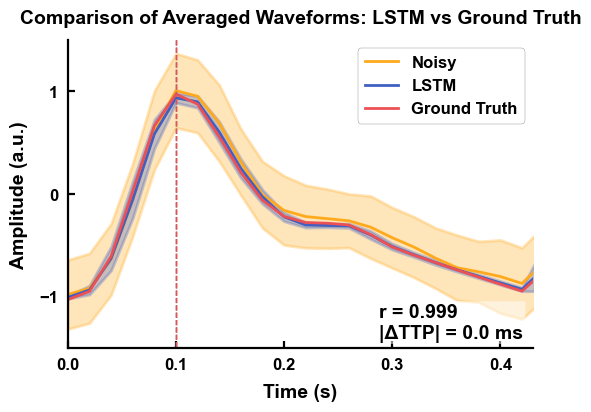

In [22]:
# Plot pulse mean and std (shaded)
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot()

# Plot noisy mean with shaded std
# Note: If normalization in preprocessing was appropriate, the averaged raw and LSTM-processed
# waveforms should be comparable in amplitude and lie roughly within [-1, 1].
ax.plot(x_noisy, mean_noisy, color=color5[2], label='Noisy', linewidth=1)
ax.fill_between(x_noisy, mean_noisy - std_noisy,
                mean_noisy + std_noisy, color=color5[2], alpha=0.3)

# Plot processed mean with shaded std
ax.plot(x_lstm, mean_lstm, color=color5[1], label='LSTM', linewidth=1)
ax.fill_between(x_lstm, mean_lstm - std_lstm,
                mean_lstm + std_lstm, color=color5[1], alpha=0.3)

# Plot ground truth mean + shaded std
ax.plot(x_gt, mean_gt, color=color5[0], label='Ground Truth', linewidth=1)
# ax.fill_between(x_gt, mean_gt - std_gt, mean_gt + std_gt,
#                 color=color5[0], alpha=0.30, linewidth=0)

ax.vlines(x = ttp_noisy, ymin=-5, ymax=5, color = color5[2], linestyle='--', linewidth=0.5)
ax.vlines(x = ttp_lstm, ymin=-5, ymax=5, color = color5[1], linestyle='--', linewidth=0.5)
ax.vlines(x = ttp_gt, ymin=-5, ymax=5, color = color5[0], linestyle='--', linewidth=0.5)

ax.text(
    0.98, 0.02,   # near bottom-right corner of the axes
    f"r = {r_pearson:.3f}\n|ΔTTP| = {delta_ttp*1000:.1f} ms",
    transform=ax.transAxes,
    ha="right", va="bottom", fontsize=7, fontweight='bold',
    multialignment="left",   # makes the lines align left *within* the box
    bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.5, linewidth=0)
)

# Labels, legend, cosmetics
ax.set_title('Comparison of Averaged Waveforms: LSTM vs Ground Truth', fontsize=7)
ax.set_xlabel('Time (s)', fontsize=7)
ax.set_ylabel('Amplitude (a.u.)', fontsize=7)

lgd = ax.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=1, loc=1)
lgd.get_frame().set_linewidth(0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xlim(0, 0.43)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_ylim(-1.5, 1.5)
ax.set_yticks([-1, 0, 1])


# Save the figure if needed
# plt.savefig('lstm_gt_averaged_waveform.png', dpi=600, bbox_inches='tight')

plt.show()


## 6. Quantitative Analyses: Peak/Valley Identification, IBI and HR accuray

### Peak and valley analyses
Evaluate peaks and valleys against ground truth for the three methods we have: LSTM, DWT, and TDDR. A ±60 ms tolerance is set by default (equivalent to 3 data points for 50 Hz sampling frequency). We will report TP/FP/FN, precision/recall/F1, and timing error stats (bias, SD, MAE, RMSE, 95th percentile of |error|)

**Identify peaks and valleys**:

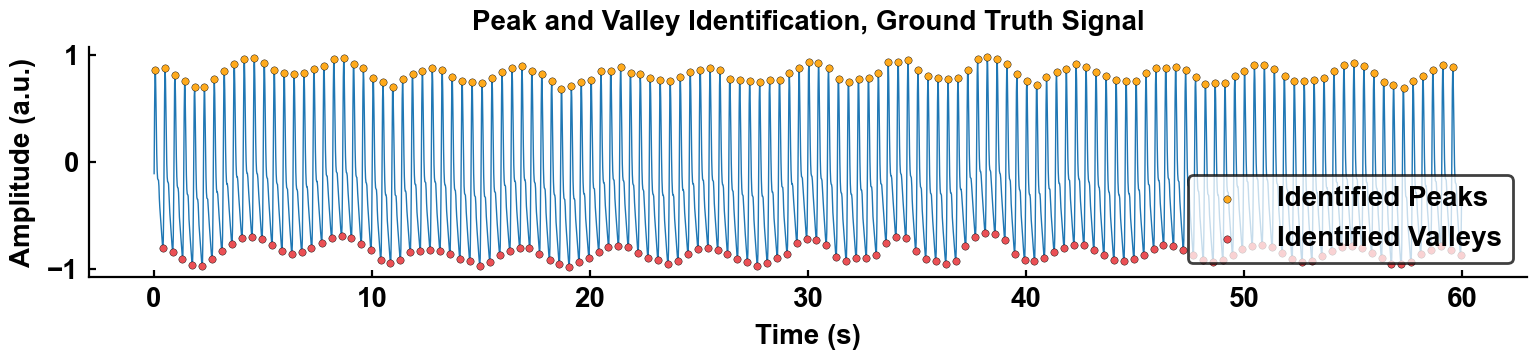

Ground truth HR is 132 bpm.


In [23]:
# Extract IBI and instantaneous HR from the ground truth signal
peak_times_gt, peak_heights_gt, ibi_gt, hr_gt = extract_ibi_hr(data_clean.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)
valley_times_gt, valley_heights_gt, _, _ = extract_ibi_hr(-data_clean.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,data_clean.squeeze(),linewidth=0.5)
ax.scatter(peak_times_gt,peak_heights_gt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_gt,-valley_heights_gt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification, Ground Truth Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()

hr_gt_bpm = len(peak_times_gt) # This is a 60 seconds signal
print("Ground truth HR is " + str(hr_gt_bpm) + " bpm.")

# or use this function to plot
# plot_signal_ibi_hr(data_clean.squeeze(), fs_target, peak_times_gt, peak_heights_gt, ibi_gt, 60*hr_gt)


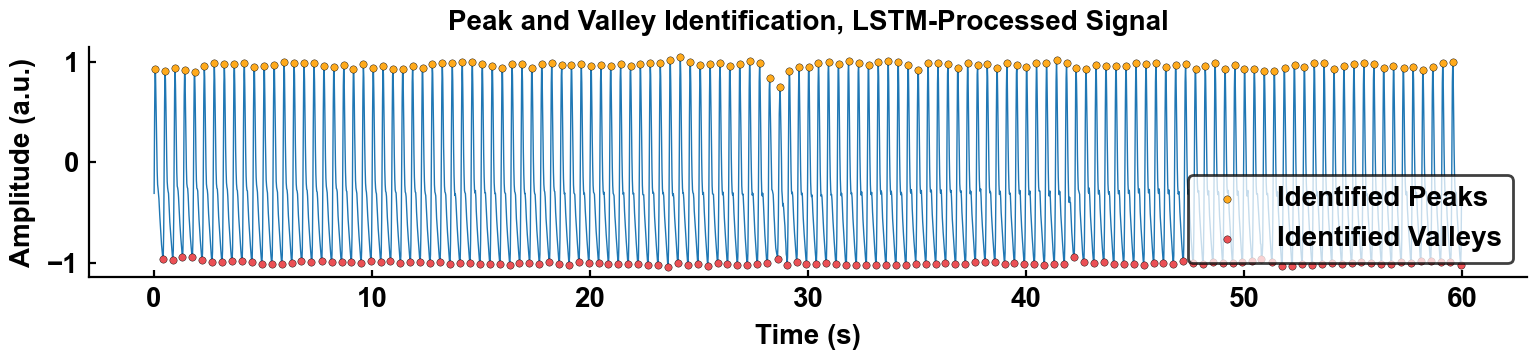

In [24]:
# IBI and HR from the LSTM processed signal
peak_times_lstm, peak_heights_lstm, ibi_lstm, hr_lstm = extract_ibi_hr(processed_time_trace.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)
valley_times_lstm, valley_heights_lstm, _, _ = extract_ibi_hr(-processed_time_trace.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,processed_time_trace.squeeze(),linewidth=0.5)
ax.scatter(peak_times_lstm,peak_heights_lstm, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_lstm,-valley_heights_lstm, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification, LSTM-Processed Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


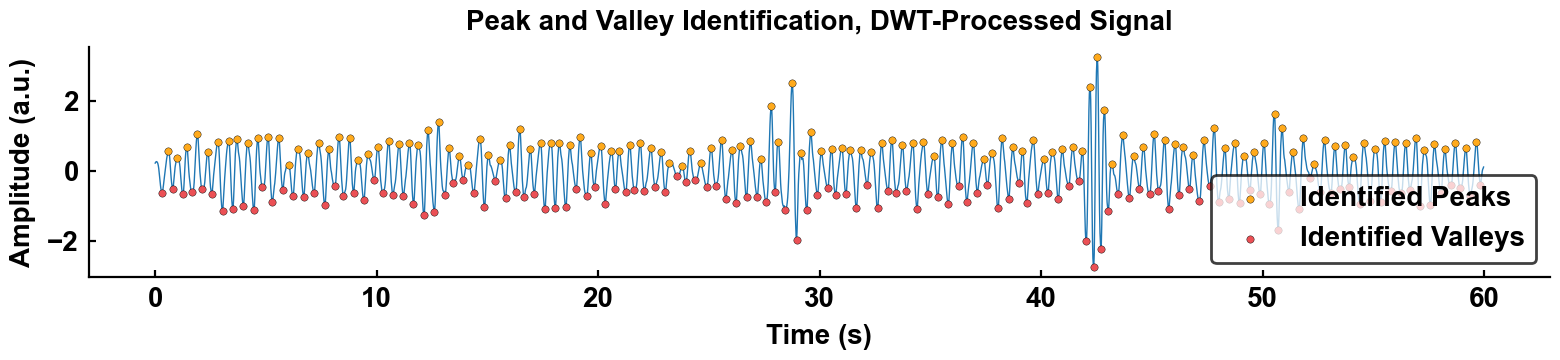

In [25]:
# IBI and HR from the wavelet processed signal
peak_times_wt, peak_heights_wt, ibi_wt, hr_wt = extract_ibi_hr(wt_corrected.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)
valley_times_wt, valley_heights_wt, _, _ = extract_ibi_hr(-wt_corrected.squeeze(), fs_target, height=0.1, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,wt_corrected.squeeze(),linewidth=0.5)
ax.scatter(peak_times_wt,peak_heights_wt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_wt,-valley_heights_wt, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification, DWT-Processed Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


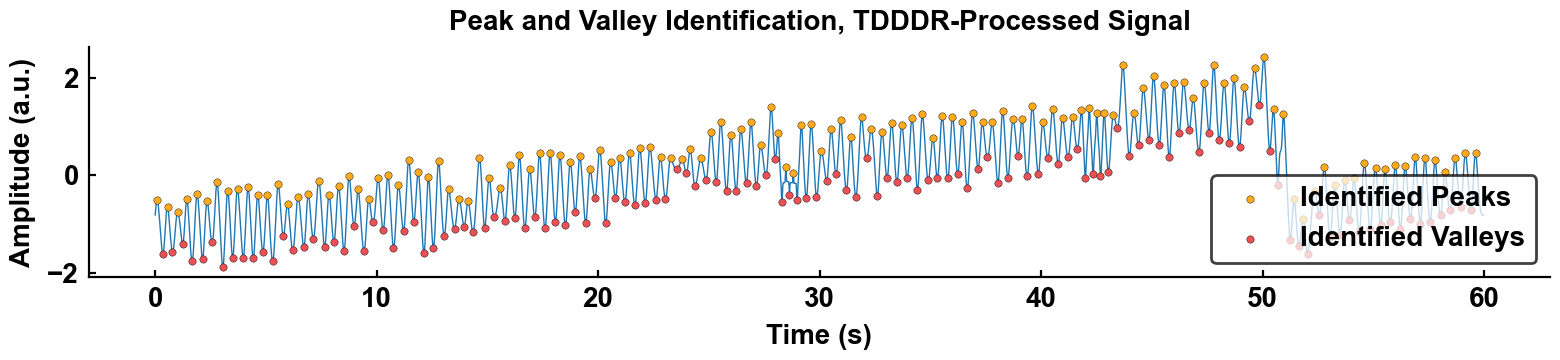

In [26]:
# IBI and HR from the TDDR processed signal
peak_times_tddr, peak_heights_tddr, ibi_tddr, hr_tddr = extract_ibi_hr(tddr_corrected.squeeze(), fs_target, prominence=0.1, distance=0.25*fs_target)
valley_times_tddr, valley_heights_tddr, _, _ = extract_ibi_hr(-tddr_corrected.squeeze(), fs_target, prominence=0.1, distance=0.25*fs_target)

fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(t_nirs,tddr_corrected.squeeze(),linewidth=0.5)
ax.scatter(peak_times_tddr,peak_heights_tddr, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[2], zorder=2, label='Identified Peaks')
ax.scatter(valley_times_tddr,-valley_heights_tddr, marker='o', edgecolors='black', linewidth=0.15, s=7, color=color5[0], zorder=2, label='Identified Valleys')
ax.legend(frameon=True, framealpha=0.75, loc=4)
ax.set_title("Peak and Valley Identification, TDDDR-Processed Signal")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude (a.u.)")

plt.tight_layout()
plt.show()


**Functions for matching detected peaks/valleys to the ground truth ones:**

In [27]:
def match_events(gt_times, est_times, tol_s):
    """
    One-to-one greedy nearest-neighbor matching within ±tol_s.
    Returns: (idx_gt, idx_est, dt) where dt = est_time - gt_time for matched pairs.
    """
    gt = np.asarray(gt_times, dtype=float).ravel()
    est = np.asarray(est_times, dtype=float).ravel()
    if gt.size == 0 or est.size == 0:
        return np.array([], int), np.array([], int), np.array([], float)

    used_gt = np.zeros(gt.size, dtype=bool)
    idx_gt, idx_est, dt = [], [], []
    for j, te in enumerate(est):
        # nearest GT index to this estimate
        i = int(np.argmin(np.abs(gt - te)))
        if not used_gt[i] and abs(gt[i] - te) <= tol_s:
            used_gt[i] = True
            idx_gt.append(i)
            idx_est.append(j)
            dt.append(te - gt[i])

    return np.asarray(idx_gt, int), np.asarray(idx_est, int), np.asarray(dt, float)

def stats_timing(errors_s):
    """
    Timing error stats from array of dt (seconds).
    Returns dict with bias (s), sd (s), mae (s), rmse (s), p95_abs (s).
    """
    e = np.asarray(errors_s, float)
    if e.size == 0:
        return dict(bias=np.nan, sd=np.nan, mae=np.nan, rmse=np.nan, p95_abs=np.nan, n=0)
    return dict(
        bias = float(np.mean(e)),
        sd   = float(np.std(e, ddof=1)) if e.size > 1 else 0.0,
        mae  = float(np.mean(np.abs(e))),
        rmse = float(np.sqrt(np.mean(e**2))),
        p95_abs = float(np.percentile(np.abs(e), 95)),
        n = int(e.size)
    )

def detection_metrics(n_gt, n_est, n_matched):
    tp = int(n_matched)
    fn = int(n_gt - n_matched)
    fp = int(n_est - n_matched)
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall    = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    f1 = (2*precision*recall / (precision + recall)) if np.isfinite(precision) and np.isfinite(recall) and (precision+recall) > 0 else np.nan
    return dict(TP=tp, FP=fp, FN=fn, precision=precision, recall=recall, f1=f1)

def evaluate_events_one(gt_times, est_times, label, tol_s=0.06):
    """
    Evaluate a single method vs ground truth for either peaks or valleys.
    Prints a concise summary and returns a result dict.
    """
    idx_gt, idx_est, dt = match_events(gt_times, est_times, tol_s)
    det = detection_metrics(len(gt_times), len(est_times), len(dt))
    st  = stats_timing(dt)
    print(f"\n[{label}]  tol = ±{1000*tol_s:.0f} ms")
    print(f"  Counts: GT={len(gt_times)}, EST={len(est_times)}, TP={det['TP']}, FP={det['FP']}, FN={det['FN']}")
    print(f"  Detect: Precision={det['precision']:.3f}  Recall={det['recall']:.3f}  F1={det['f1']:.3f}")
    print(f"  Timing (matched {st['n']}): "
          f"bias={st['bias']*1000:.1f} ms, sd={st['sd']*1000:.1f} ms, "
          f"MAE={st['mae']*1000:.1f} ms, RMSE={st['rmse']*1000:.1f} ms, "
          f"P95|err|={st['p95_abs']*1000:.1f} ms")
    return dict(detection=det, timing_stats_s=st, matched_pairs=(idx_gt, idx_est), dt_s=dt)


**Results: detections accuracy**

In [28]:
def evaluate_peaks_and_valleys(tol_s):
    results = {}

    # --- Peaks ---
    results['peaks_lstm'] = evaluate_events_one(peak_times_gt,   peak_times_lstm,  "Peaks • LSTM", tol_s)
    results['peaks_wt']   = evaluate_events_one(peak_times_gt,   peak_times_wt,    "Peaks • DWT/Wavelet", tol_s)
    results['peaks_tddr'] = evaluate_events_one(peak_times_gt,   peak_times_tddr,  "Peaks • TDDR", tol_s)

    # --- Valleys ---
    results['valleys_lstm'] = evaluate_events_one(valley_times_gt, valley_times_lstm, "Valleys • LSTM", tol_s)
    results['valleys_wt']   = evaluate_events_one(valley_times_gt, valley_times_wt,   "Valleys • DWT/Wavelet", tol_s)
    results['valleys_tddr'] = evaluate_events_one(valley_times_gt, valley_times_tddr, "Valleys • TDDR", tol_s)

    return results

In [29]:
tol_ms = 60.0 # change this to try difference tolerance
tol_s = 0.001*tol_ms

results_peak_valley = evaluate_peaks_and_valleys(tol_s)


[Peaks • LSTM]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detect: Precision=1.000  Recall=1.000  F1=1.000
  Timing (matched 132): bias=-0.0 ms, sd=8.9 ms, MAE=3.9 ms, RMSE=8.9 ms, P95|err|=20.0 ms

[Peaks • DWT/Wavelet]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=88, FP=44, FN=44
  Detect: Precision=0.667  Recall=0.667  F1=0.667
  Timing (matched 88): bias=21.8 ms, sd=24.8 ms, MAE=27.7 ms, RMSE=32.9 ms, P95|err|=60.0 ms

[Peaks • TDDR]  tol = ±60 ms
  Counts: GT=132, EST=134, TP=108, FP=26, FN=24
  Detect: Precision=0.806  Recall=0.818  F1=0.812
  Timing (matched 108): bias=30.7 ms, sd=15.3 ms, MAE=31.5 ms, RMSE=34.3 ms, P95|err|=40.0 ms

[Valleys • LSTM]  tol = ±60 ms
  Counts: GT=132, EST=132, TP=132, FP=0, FN=0
  Detect: Precision=1.000  Recall=1.000  F1=1.000
  Timing (matched 132): bias=-2.7 ms, sd=9.8 ms, MAE=4.8 ms, RMSE=10.2 ms, P95|err|=20.0 ms

[Valleys • DWT/Wavelet]  tol = ±60 ms
  Counts: GT=132, EST=133, TP=45, FP=88, FN=87
  Detect: Precision=0.338  R

### IBI/HR comparison

**Functions for matching IBI/HR, smoothing, and calculating MAE and RMSE:**

In [30]:
from scipy.interpolate import interp1d

def _pearson_r(a, b):
    return np.corrcoef(a, b)[0, 1]

def _restrict_to_common_range(t1, y1, t2, y2, eps=1e-12):
    """
    Trim both (t, y) series to their TRUE overlap [tmin, tmax] so we never extrapolate.
    """
    if len(t1) == 0 or len(t2) == 0:
        return np.array([]), np.array([]), np.array([]), np.array([])
    tmin = max(float(np.min(t1)), float(np.min(t2)))
    tmax = min(float(np.max(t1)), float(np.max(t2)))
    if not (tmax > tmin):
        return np.array([]), np.array([]), np.array([]), np.array([])
    m1 = (t1 >= tmin - eps) & (t1 <= tmax + eps)
    m2 = (t2 >= tmin - eps) & (t2 <= tmax + eps)
    return t1[m1], y1[m1], t2[m2], y2[m2]

def compare_ibi_on_shorter_axis(peak_times_gt, ibi_gt, peak_times_est, ibi_est, label="Method"):
    """
    Compare IBI series by interpolating onto the SHORTER axis within the common overlap.
    IBI time axis = start-of-interval times: t = peak_times[:-1]
    No extrapolation (hard-masked to interpolation domain).

    Returns
    -------
    dict with:
      - mae_ms, rmse_ms, r, N
      - t_axis: np.ndarray, the time axis actually used for comparison (seconds)
      - ibi_gt_aligned: np.ndarray, GT IBI values aligned to t_axis (seconds)
      - ibi_est_aligned: np.ndarray, EST IBI values aligned to t_axis (seconds)
    """
    peak_times_gt  = np.asarray(peak_times_gt,  float).ravel()
    peak_times_est = np.asarray(peak_times_est, float).ravel()
    ibi_gt  = np.asarray(ibi_gt,  float).ravel()
    ibi_est = np.asarray(ibi_est, float).ravel()

    # IBI time axes: start-of-interval times
    t_gt  = peak_times_gt[:-1]
    t_est = peak_times_est[:-1]

    # Trim to true overlap so we never extrapolate
    t_gt_c, ibi_gt_c, t_est_c, ibi_est_c = _restrict_to_common_range(t_gt, ibi_gt, t_est, ibi_est)
    if t_gt_c.size < 2 or t_est_c.size < 2:
        print(f"[{label}] Not enough overlapping points for interpolation.")
        return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}

    # Choose target = shorter clipped axis
    if t_gt_c.size <= t_est_c.size:
        t_target_full = t_gt_c
        y_ref = ibi_gt_c
        dom_lo, dom_hi = t_est_c[0], t_est_c[-1]
        mask = (t_target_full >= dom_lo) & (t_target_full <= dom_hi)
        t_axis = t_target_full[mask]
        y_ref  = y_ref[mask]
        if t_axis.size < 2:
            print(f"[{label}] Overlap after domain mask too small.")
            return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                    "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
        f_est = interp1d(t_est_c, ibi_est_c, kind="linear", bounds_error=False, fill_value=np.nan, assume_sorted=False)
        y_other = f_est(t_axis)
        ibi_gt_aligned, ibi_est_aligned = y_ref, y_other
    else:
        t_target_full = t_est_c
        y_ref = ibi_est_c
        dom_lo, dom_hi = t_gt_c[0], t_gt_c[-1]
        mask = (t_target_full >= dom_lo) & (t_target_full <= dom_hi)
        t_axis = t_target_full[mask]
        y_ref  = y_ref[mask]
        if t_axis.size < 2:
            print(f"[{label}] Overlap after domain mask too small.")
            return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                    "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
        f_gt = interp1d(t_gt_c, ibi_gt_c, kind="linear", bounds_error=False, fill_value=np.nan, assume_sorted=False)
        y_other = f_gt(t_axis)
        ibi_gt_aligned, ibi_est_aligned = y_other, y_ref

    # Remove any residual NaNs (shouldn’t occur after masking, but keep safe)
    m = np.isfinite(ibi_gt_aligned) & np.isfinite(ibi_est_aligned)
    if np.count_nonzero(m) < 2:
        print(f"[{label}] Too few valid samples after alignment.")
        return {"mae_ms": np.nan, "rmse_ms": np.nan, "r": np.nan, "N": 0,
                "t_axis": np.array([]), "ibi_gt_aligned": np.array([]), "ibi_est_aligned": np.array([])}
    t_axis        = t_axis[m]
    ibi_gt_aligned  = ibi_gt_aligned[m]
    ibi_est_aligned = ibi_est_aligned[m]

    # Metrics
    err     = ibi_est_aligned - ibi_gt_aligned  # seconds
    mae_ms  = float(np.mean(np.abs(err)) * 1000.0)
    rmse_ms = float(np.sqrt(np.mean(err**2)) * 1000.0)
    r_val   = _pearson_r(ibi_gt_aligned, ibi_est_aligned)
    N       = int(t_axis.size)

    # print(f"[{label}] IBI on shorter overlap axis: N={N}, "
    #       f"MAE={mae_ms:.1f} ms, RMSE={rmse_ms:.1f} ms, r={r_val:.3f}")

    return {
        "mae_ms": mae_ms, "rmse_ms": rmse_ms, "r": r_val, "N": N,
        "t_axis": t_axis,                         # seconds
        "ibi_gt_aligned": ibi_gt_aligned,         # seconds
        "ibi_est_aligned": ibi_est_aligned        # seconds
    }

def _smooth_beats(x, k):
    if k is None or k <= 1:
        return x
    k = int(k)
    if k % 2 == 0:
        k += 1  # force odd for centering
    w = np.ones(k, dtype=float) / k
    # 'same' keeps length; pad with edge values to avoid shrinkage
    pad = k // 2
    xp = np.pad(x, (pad, pad), mode='edge')
    return np.convolve(xp, w, mode='valid')

def compare_ibi_on_shorter_axis_with_hr_smoothing(
    peak_times_gt, ibi_gt, peak_times_est, ibi_est, label="Method", hr_smooth_beats=1
):
    res = compare_ibi_on_shorter_axis(peak_times_gt, ibi_gt, peak_times_est, ibi_est, label=label)

    # If alignment failed or too few points, just return unchanged keys plus NaNs for smoothed HR
    if res["N"] < 2 or res["ibi_gt_aligned"].size < 2:
        res.update({
            "hr_mae_bpm_smooth": np.nan,
            "hr_rmse_bpm_smooth": np.nan,
            "hr_r_smooth": np.nan,
        })
        return res

    # Build HR from aligned IBIs (seconds → bpm)
    ibi_gt_aln  = res["ibi_gt_aligned"]
    ibi_est_aln = res["ibi_est_aligned"]
    mpos = (ibi_gt_aln > 0) & (ibi_est_aln > 0) & np.isfinite(ibi_gt_aln) & np.isfinite(ibi_est_aln)
    if np.count_nonzero(mpos) < 2:
        res.update({
            "hr_mae_bpm_smooth": np.nan,
            "hr_rmse_bpm_smooth": np.nan,
            "hr_r_smooth": np.nan,
        })
        return res

    hr_gt  = 60.0 / ibi_gt_aln[mpos]
    hr_est = 60.0 / ibi_est_aln[mpos]

    # Optional beat-smoothing (identical on both)
    hr_gt_s  = _smooth_beats(hr_gt,  hr_smooth_beats)
    hr_est_s = _smooth_beats(hr_est, hr_smooth_beats)

    # Align lengths after smoothing (edges can differ by at most a beat)
    L = min(hr_gt_s.size, hr_est_s.size)
    hr_gt_s, hr_est_s = hr_gt_s[:L], hr_est_s[:L]

    # Metrics on smoothed HR
    diff = hr_est_s - hr_gt_s
    hr_mae_bpm_s  = float(np.mean(np.abs(diff)))
    hr_rmse_bpm_s = float(np.sqrt(np.mean(diff**2)))
    hr_r_s        = float(np.corrcoef(hr_gt_s, hr_est_s)[0, 1]) if L > 1 else np.nan

    res.update({
        "hr_mae_bpm_smooth": hr_mae_bpm_s,
        "hr_rmse_bpm_smooth": hr_rmse_bpm_s,
        "hr_r_smooth": hr_r_s,
        "hr_gt_smoothed": hr_gt_s, "hr_est_smoothed": hr_est_s, # for plotting
    })

    # Optional print for visibility (comment out if noisy)
    print(f"[{label}] HR (smoothed over {hr_smooth_beats} beats): "
          f"MAE={hr_mae_bpm_s:.2f} bpm, RMSE={hr_rmse_bpm_s:.2f} bpm, r={hr_r_s:.3f}")

    return res


**Results:**

**Note:** While MAE and RMSE between LSTM-derived and ground-truth HR are low, the Pearson correlation (r) appears modest. This is expected because the mean HR is nearly constant across the 60-s window, so even small beat-to-beat differences (1–2 samples in IBI) disproportionately reduce r. In other words, the traces are highly consistent in absolute terms, but correlation is less informative under near-constant HR conditions.


In [31]:
hr_smooth_beats = 5 # smooth over N beats

result_hr_lstm = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_lstm, ibi_lstm, label="LSTM", hr_smooth_beats=hr_smooth_beats)
result_hr_dwt = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_wt, ibi_wt, label="DWT", hr_smooth_beats=hr_smooth_beats)
result_hr_tddr = compare_ibi_on_shorter_axis_with_hr_smoothing(peak_times_gt, ibi_gt, peak_times_tddr, ibi_tddr, label="TDDR", hr_smooth_beats=hr_smooth_beats)


[LSTM] HR (smoothed over 5 beats): MAE=0.46 bpm, RMSE=0.79 bpm, r=0.669
[DWT] HR (smoothed over 5 beats): MAE=3.09 bpm, RMSE=5.68 bpm, r=-0.008
[TDDR] HR (smoothed over 5 beats): MAE=3.03 bpm, RMSE=6.64 bpm, r=0.092


**Paper figure: plot smoothed HR time traces**

**Note:** In the paper, smoothing was implemented with a simple moving average (`np.convolve` with `mode='valid'`), which shortens the signal at the edges. In this repository, we use an improved function (`_smooth_beats`) with edge padding to preserve signal length. This caused minor visual differences from the paper figures, but the results are consistent.


In [32]:
hr_gt_smoothed = result_hr_lstm['hr_gt_smoothed']
hr_lstm_smoothed = result_hr_lstm['hr_est_smoothed']
hr_wt_smoothed = result_hr_dwt['hr_est_smoothed']
hr_tddr_smoothed = result_hr_tddr['hr_est_smoothed']


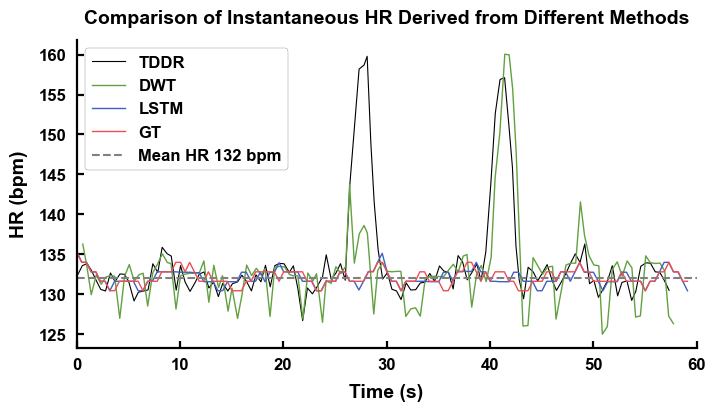

In [33]:
# Plot the HR time traces
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(peak_times_tddr[:len(hr_tddr_smoothed)], hr_tddr_smoothed,label='TDDR',linewidth=0.4,color='k')
ax.plot(peak_times_wt[:len(hr_wt_smoothed)], hr_wt_smoothed,label='DWT',linewidth=0.5,color=color5[3])
ax.plot(peak_times_lstm[:len(hr_lstm_smoothed)], hr_lstm_smoothed,label='LSTM',linewidth=0.5,color=color5[1])
ax.plot(peak_times_gt[:len(hr_gt_smoothed)], hr_gt_smoothed,label='GT',linewidth=0.5,color=color5[0])

ax.hlines(y = hr_gt_bpm, xmin=0, xmax=60, color = [0.5,0.5,0.5], linestyle='--', linewidth=0.75, label=f'Mean HR {hr_gt_bpm} bpm')

ax.set_title('Comparison of Instantaneous HR Derived from Different Methods', fontsize=7)
ax.set_xlabel('Time (s)', fontsize=7)
ax.set_ylabel('HR (bpm)', fontsize=7)


lgd = ax.legend(fontsize=6,frameon=True, framealpha=0.7, ncol=1, loc=2)
lgd.get_frame().set_linewidth(0.1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_xlim(0, 60)

# Save the figure if needed
# plt.savefig('HR_lstm_dwt_tddr_mean_HR.png', dpi=600, bbox_inches='tight')

plt.show()